In [6]:
from DataModules import MNISTSuperpixelDataModule
from DataModules.MNISTSuperpixelDataModule import DenseData, DenseElement, densify_data
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch, Dataset, Data
from torch_geometric.datasets import MNISTSuperpixels
import matplotlib.pyplot as plt
import cv2
from torch_geometric.utils import dense_to_sparse
import numpy as np



MNIST_PATH = "../datasets/MNISTSuperpixel"
data_module = MNISTSuperpixelDataModule(MNIST_PATH)
data_module.setup("fit")
loader = data_module.train_dataloader()
dense_data = next(iter(loader))

sparse_module = MNISTSuperpixels(MNIST_PATH)
sparse_loader = DataLoader(sparse_module, batch_size=32)
sparse_data = next(iter(sparse_loader))

print(dense_data)
print(sparse_data)

DenseElement(DenseData(x=(32, 75, 3), adj=(32, 75, 75), mask=(32, 75)), y=(32,))
DataBatch(x=[2400, 1], edge_index=[2, 44720], y=[32], pos=[2400, 2], batch=[2400], ptr=[33])


In [7]:
def superpixels_to_image(rec: Data, scale: int = 30, edge_width: int = 1) -> np.ndarray:
    pos = (rec.pos.clone() * scale).int()

    image = np.zeros((scale * 26, scale * 26, 1), dtype=np.uint8)
    for (color, (x, y)) in zip(rec.x, pos):
        x0, y0 = int(x), int(y)
        x1, y1 = x0 - scale, y0 - scale

        color = int(float(color + 0.15) * 255)
        color = min(color, 255)

        cv2.rectangle(image, (x0, y0), (x1, y1), color, -1)

    for node_ix_0, node_ix_1 in rec.edge_index.T:
        x0, y0 = list(map(int, pos[node_ix_0]))
        x1, y1 = list(map(int, pos[node_ix_1]))

        x0 -= scale // 2
        y0 -= scale // 2
        x1 -= scale // 2
        y1 -= scale // 2

        cv2.line(image, (x0, y0), (x1, y1), 125, edge_width)
    return image

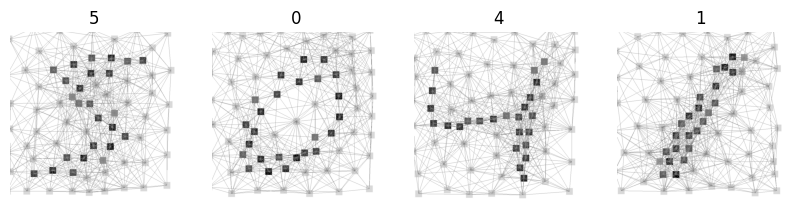

In [8]:
batch = sparse_data[:4]
fig, axes = plt.subplots(1, len(batch), figsize=(10, 6))
axes = axes.flatten()
for i in range(len(batch)):
    image = superpixels_to_image(batch[i])
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{batch[i].y.item()}")

In [9]:
batch = dense_data.data[0]
edge_index = dense_to_sparse(batch.adj)[0]
edge_index

tensor([[ 0,  0,  0,  ..., 74, 74, 74],
        [ 3,  5,  7,  ..., 66, 71, 72]])

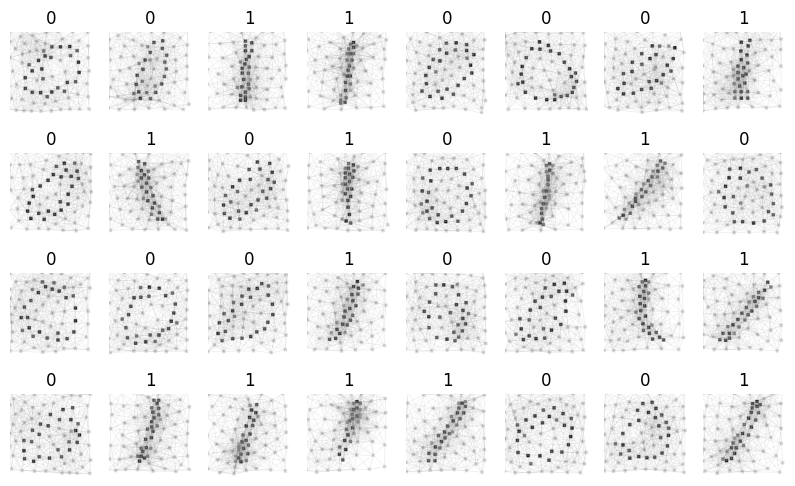

In [10]:
def superpixels_to_image(rec: DenseData, scale: int = 30, edge_width: int = 1) -> np.ndarray:
    pos = (rec.x[:,1:].clone() * scale).int()

    image = np.zeros((scale * 26, scale * 26, 1), dtype=np.uint8)
    for (color, (x, y)) in zip(rec.x[:,0], pos):
        x0, y0 = int(x), int(y)
        x1, y1 = x0 - scale, y0 - scale

        color = int(float(color + 0.15) * 255)
        color = min(color, 255)

        cv2.rectangle(image, (x0, y0), (x1, y1), color, -1)

    edge_index = dense_to_sparse(rec.adj)[0]
    for node_ix_0, node_ix_1 in edge_index.T:
        x0, y0 = list(map(int, pos[node_ix_0]))
        x1, y1 = list(map(int, pos[node_ix_1]))

        x0 -= scale // 2
        y0 -= scale // 2
        x1 -= scale // 2
        y1 -= scale // 2

        cv2.line(image, (x0, y0), (x1, y1), 125, edge_width)
    return image

batch = dense_data.data[:32]
y = dense_data.y[:32]

fig, axes = plt.subplots(4, len(batch)//4, figsize=(10, 6))
axes = axes.flatten()
for i in range(len(batch)):
    image = superpixels_to_image(batch[i])
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{y[i]}")

In [18]:
from models.ebm import DeepEnergyModel
from utils import Sampler
from utils.graphs import generate_random_graph

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CHECKPOINT_PATH = "/home/mancio/git/ebm-molecules/graph_logs/lightning_logs/version_0/checkpoints/epoch=60-step=5490.ckpt"
# CHECKPOINT_PATH = "/home/mancio/git/ebm-molecules/graph_logs/lightning_logs/version_19/checkpoints/epoch=60-step=5490.ckpt"
CHECKPOINT_PATH = "/home/mancio/git/ebm-molecules/graph_logs/lightning_logs/version_20/checkpoints/epoch=100-step=9090.ckpt"

model = DeepEnergyModel.load_from_checkpoint(CHECKPOINT_PATH).to(device)
starting_graphs: DenseData = densify_data(
            Batch.from_data_list(
                [generate_random_graph(device=model.device) for _ in range(4)]
            )
        )
labels = torch.tensor([0,0,1,1])
result: DenseData = Sampler.generate_samples(model.cnn, starting_graphs, labels, 1024)

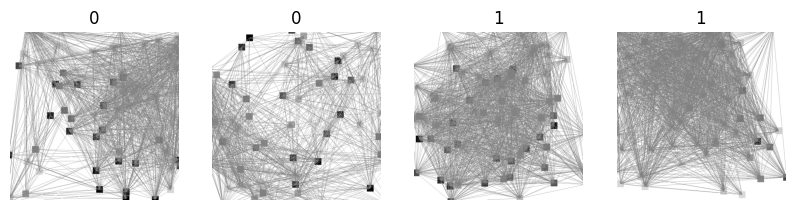

In [19]:
batch = result
y = labels

fig, axes = plt.subplots(1, len(batch), figsize=(10, 6))
axes = axes.flatten()
for i in range(len(batch)):
    image = superpixels_to_image(batch[i])
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{y[i]}")